In [1]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

# Lecture 5: Visualization Part 1

## seaborn

seaborn is the primary visualization library we will use in Data 100. See the complete API here: https://seaborn.pydata.org/api.html

In [3]:
tips = sns.load_dataset('tips')
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
...,...,...,...,...,...,...,...
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


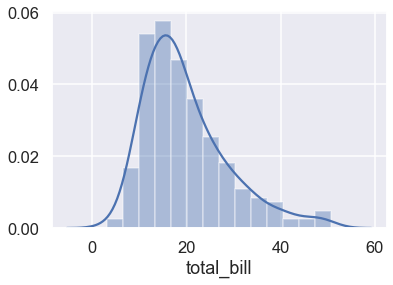

In [4]:
sns.distplot(tips['total_bill']);

Most seaborn methods use the `x` and `y` arguments. Notice that the grouping is done automatically! This is why we use tidy data for seaborn.

In [5]:
tips[['day', 'total_bill']]

,day,total_bill
0,Sun,16.99
1,Sun,10.34
2,Sun,21.01
...,...,...
241,Sat,22.67
242,Sat,17.82
243,Thur,18.78


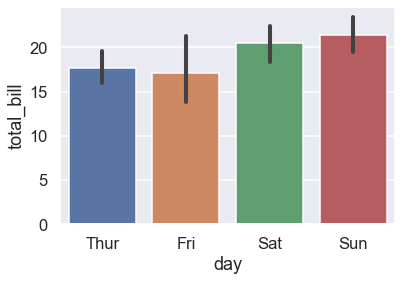

In [6]:
# Grouped by day
sns.barplot(x="day", y="total_bill", data=tips);

What do you observe?

The same syntax works across most of seaborn's methods. Notice that the plot automatically has a regression line with a 95% bootstrap CI.

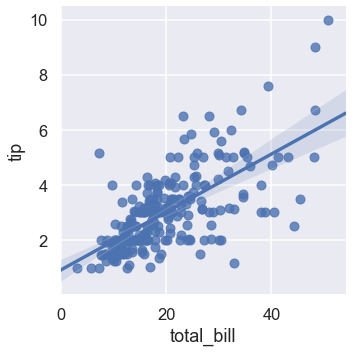

In [7]:
sns.lmplot(x='total_bill', y='tip', data=tips);

With lots of data, the 95% CI takes a long time to compute so we can turn it off.

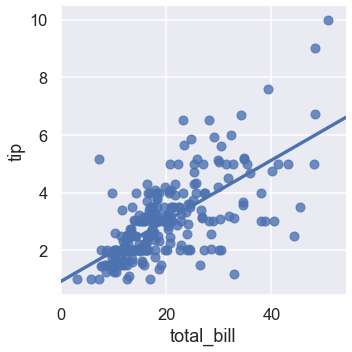

In [8]:
sns.lmplot(x='total_bill', y='tip', data=tips, ci=False);

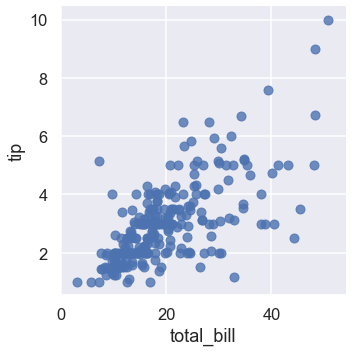

In [9]:
sns.lmplot(x='total_bill', y='tip', data=tips, fit_reg=False);

seaborn really shines when plotting multiple variables using the `hue`, `row,` and `col` arguments. (Only the "Facet" type methods have `row` and `col`, like `lmplot()` and `relplot()`.)

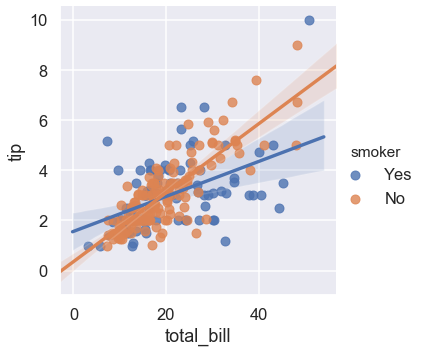

In [10]:
sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips);

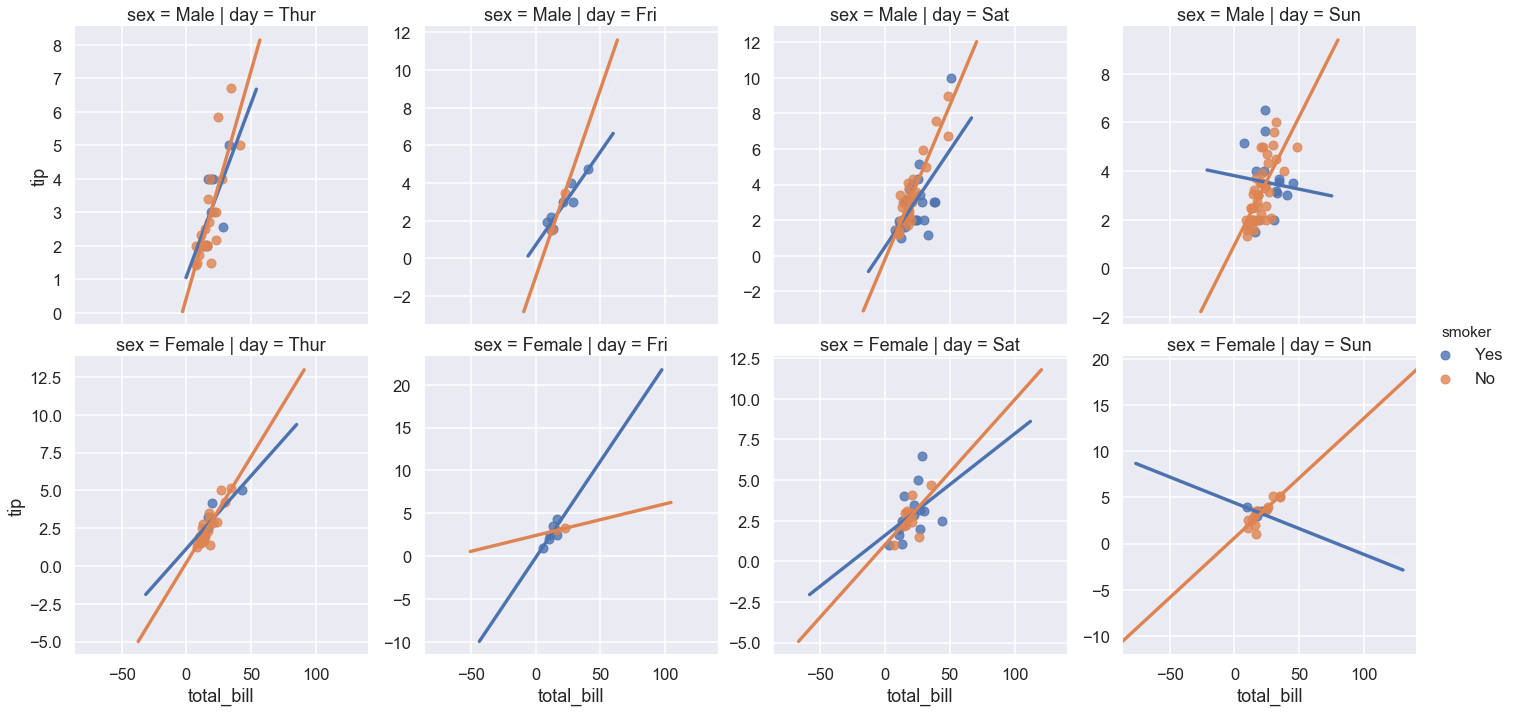

In [11]:
sns.lmplot(x="total_bill", y="tip", hue="smoker",
           row='sex', col='day', sharey=False, ci=False,
           data=tips);

In [12]:
fmri = sns.load_dataset("fmri")
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-1.76e-02
1,s5,14,stim,parietal,-8.09e-02
2,s12,18,stim,parietal,-8.10e-02
...,...,...,...,...,...
1061,s12,7,cue,frontal,-4.94e-03
1062,s11,7,cue,frontal,-2.54e-02
1063,s0,0,cue,parietal,-6.90e-03


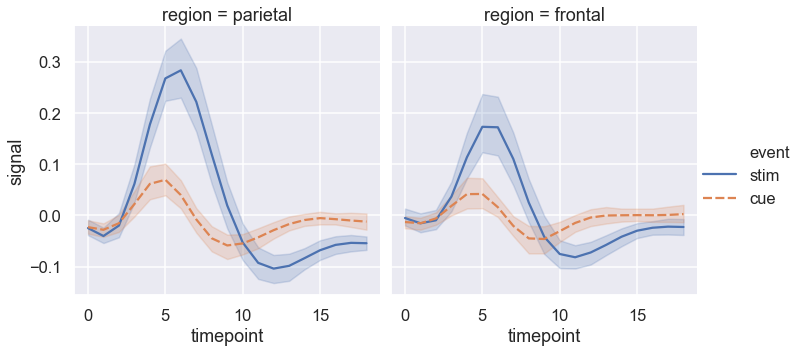

In [13]:
sns.relplot(x="timepoint", y="signal",
            hue="event", style="event", col="region",
            kind="line", data=fmri)

seaborn comes with a few built-in plot styles:

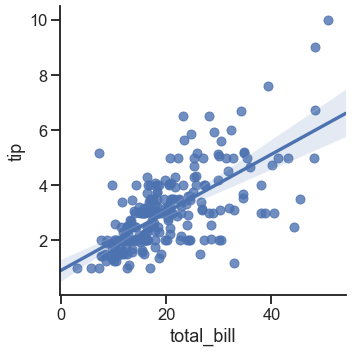

In [14]:
with sns.axes_style('ticks'):
    sns.lmplot(x='total_bill', y='tip', data=tips);

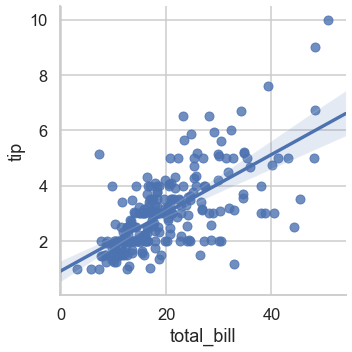

In [15]:
with sns.axes_style('whitegrid'):
    sns.lmplot(x='total_bill', y='tip', data=tips);

In [16]:
def sinplot(flip=1):
    x = np.linspace(0, 14, 100)
    for i in range(1, 7):
        plt.plot(x, np.sin(x + i * .5) * (7 - i) * flip)

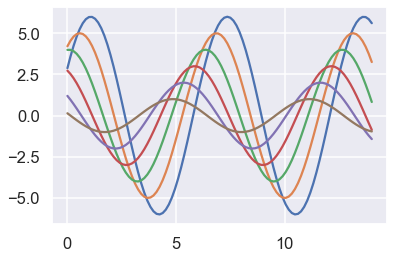

In [17]:
sinplot()

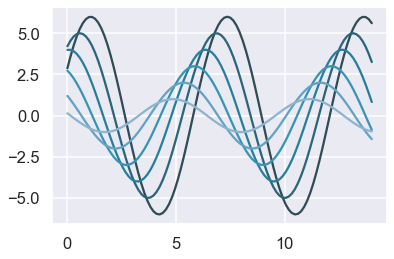

In [18]:
with sns.color_palette("PuBuGn_d"):
    sinplot()

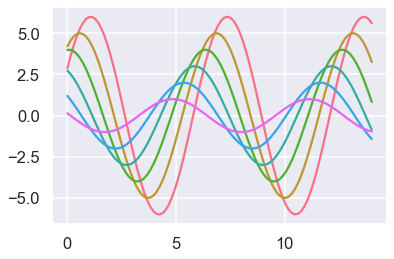

In [19]:
with sns.color_palette("husl"):
    sinplot()

## matplotlib

matplotlib is the underlying library behind most of the Python plotting ecosystem. It provides low-level drawing functionality that we need to make detailed adjustments to our plots. This library is very large and we won't cover all of it during class.

For further reading:

* The [official matplotlib documentation](https://matplotlib.org/contents.html) is detailed and comprehensive. Particularly useful sections are:
  - The [gallery](https://matplotlib.org/gallery/index.html).
  - The [high level overview of its dual APIs, `pyplot` and object-oriented](https://matplotlib.org/api/pyplot_summary.html).
  - The [topical tutorials](https://matplotlib.org/tutorials/index.html).


* A detailed [tutorial](https://www.labri.fr/perso/nrougier/teaching/matplotlib) by Nicolas Rougier, similar in style to the ones we saw for Numpy.
* The fantastic [Python Graph Gallery](https://python-graph-gallery.com), which provides a large collection of plots with emphasis on statistical visualizations.  It uses [Seaborn](https://seaborn.pydata.org) extensively.


## Matplotlib's main APIs: ``pyplot`` and object-oriented

Matplotlib is a library that can be thought of as having two main ways of being
used:

- via ``pyplot`` calls, as a high-level, matlab-like library that automatically
  manages details like figure creation.

- via its internal object-oriented structure, that offers full control over all
  aspects of the figure, at the cost of slightly more verbose calls for the
  common case.

The pyplot api:

- Easiest to use.
- Sufficient for simple and moderately complex plots.
- Does not offer complete control over all details.

Before we look at our first simple example, we must activate matplotlib support in the notebook:

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
# a few widely used tools from numpy
from numpy import sin, cos, exp, sqrt, pi, linspace, arange

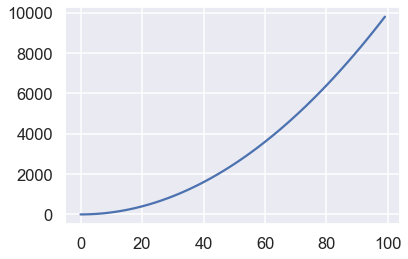

In [35]:
xs = arange(0, 100)
ys = xs ** 2
plt.plot(xs, ys)

The `plt` module has useful methods for adding labels and legends to plots.

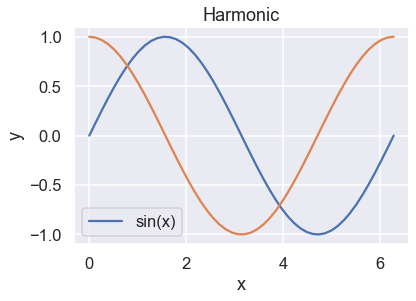

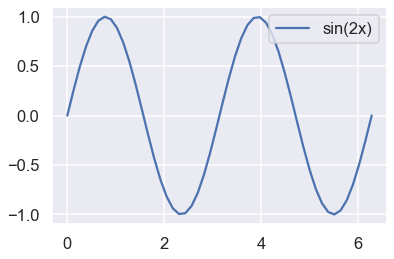

In [21]:
x = linspace(0, 2 * pi)
y = sin(x)
plt.plot(x, y, label='sin(x)')
plt.legend()
plt.title('Harmonic')
plt.xlabel('x')
plt.ylabel('y')

# Add one line to that plot
z = cos(x)
plt.plot(x, z, label='cos(x)')

# Make a second figure with a simple plot
plt.figure()
plt.plot(x, sin(2*x), label='sin(2x)')
plt.legend();

Here is how to create the same two plots, using explicit management of the figure and axis objects:

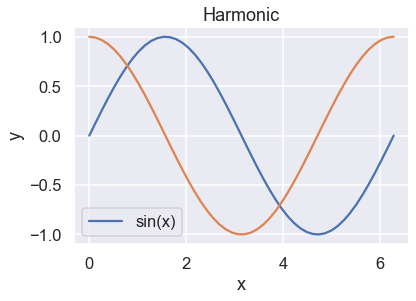

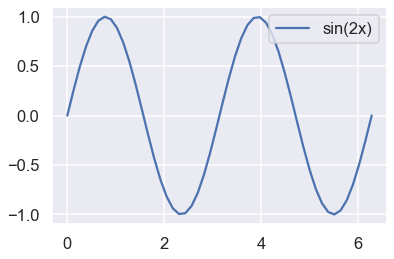

In [22]:
f, ax = plt.subplots()  # we manually make a figure and axis
ax.plot(x,y, label='sin(x)')  # it's the axis who plots
ax.legend()
ax.set_title('Harmonic')  # we set the title on the axis
ax.set_xlabel('x')  # same with labels
ax.set_ylabel('y')

# Make a second figure with a simple plot.  We can name the figure with a
# different variable name as well as its axes, and then control each
f1, ax1 = plt.subplots()
ax1.plot(x, sin(2*x), label='sin(2x)')
ax1.legend()

# Since we now have variables for each axis, we can add back to the first
# figure even after making the second
ax.plot(x, z, label='cos(x)');

It’s important to understand the existence of these objects, even if you use mostly the top-level pyplot calls most of the time. Many things can be accomplished in MPL with mostly pyplot and a little bit of tweaking of the underlying objects. We’ll revisit the object-oriented API later.

Important commands to know about, and which matplotlib uses internally a lot:

    gcf()  # get current figure
    gca()  # get current axis

## Making subplots


The simplest command is:

    f, ax = plt.subplots()

which is equivalent to:

    f = plt.figure()
    ax = f.add_subplot(111)

By passing arguments to `subplots`, you can easily create a regular plot grid:

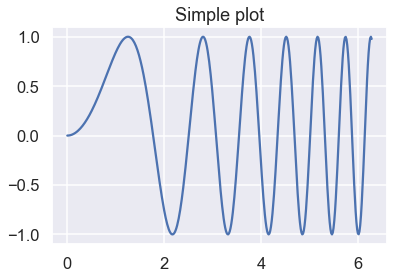

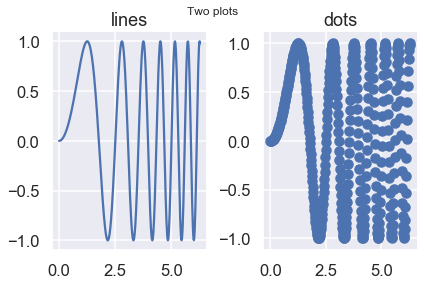

In [23]:
x = linspace(0, 2*pi, 400)
y = sin(x**2)

# Just a figure and one subplot
f, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Two subplots, unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, y)
ax1.set_title('lines')
ax2.scatter(x, y)
ax2.set_title('dots')

# Put a figure-level title
f.suptitle('Two plots')

# Ask matplotlib to auto-adjust whitespace surrounding axes
plt.tight_layout()

And finally, an arbitrarily complex grid can be made with ``subplot2grid``:

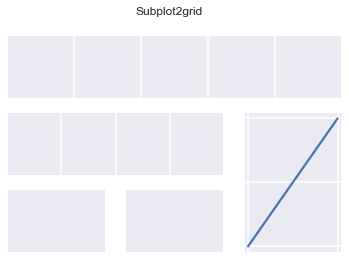

In [24]:
f = plt.figure()
ax1 = plt.subplot2grid((3,3), (0,0), colspan=3)
ax2 = plt.subplot2grid((3,3), (1,0), colspan=2)
ax3 = plt.subplot2grid((3,3), (1, 2), rowspan=2)
ax4 = plt.subplot2grid((3,3), (2, 0))
ax5 = plt.subplot2grid((3,3), (2, 1))

# Let's turn off visibility of all tick labels here
for ax in f.axes:
   for t in ax.get_xticklabels()+ax.get_yticklabels():
       t.set_visible(False)

# And add a figure-level title at the top
f.suptitle('Subplot2grid')

# Plot something at the bottom right
ax3.plot([1, 2, 3]);

## Manipulating properties across matplotlib

In matplotlib, most properties for lines, colors, etc, can be set directly in
the call:

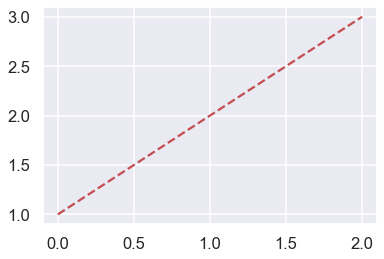

In [25]:
plt.plot([1,2,3], linestyle='--', color='r')

But for finer control you can get a hold of the returned line object (more on
these objects later):

    In [1]: line, = plot([1,2,3])

These line objects have a lot of properties you can control, a full list is
seen here by tab-completing in IPython:

    In [2]: line.set
    line.set                     line.set_drawstyle           line.set_mec
    line.set_aa                  line.set_figure              line.set_mew
    line.set_agg_filter          line.set_fillstyle           line.set_mfc
    line.set_alpha               line.set_gid                 line.set_mfcalt
    line.set_animated            line.set_label               line.set_ms
    line.set_antialiased         line.set_linestyle           line.set_picker
    line.set_axes                line.set_linewidth           line.set_pickradius
    line.set_c                   line.set_lod                 line.set_rasterized
    line.set_clip_box            line.set_ls                  line.set_snap
    line.set_clip_on             line.set_lw                  line.set_solid_capstyle
    line.set_clip_path           line.set_marker              line.set_solid_joinstyle
    line.set_color               line.set_markeredgecolor     line.set_transform
    line.set_contains            line.set_markeredgewidth     line.set_url
    line.set_dash_capstyle       line.set_markerfacecolor     line.set_visible
    line.set_dashes              line.set_markerfacecoloralt  line.set_xdata
    line.set_dash_joinstyle      line.set_markersize          line.set_ydata
    line.set_data                line.set_markevery           line.set_zorder
    

But the `setp` call (short for set property) can be very useful, especially
while working interactively because it contains introspection support, so you
can learn about the valid calls as you work:

    In [7]: line, = plot([1,2,3])

    In [8]: setp(line, 'linestyle')
      linestyle: [ ``'-'`` | ``'--'`` | ``'-.'`` | ``':'`` | ``'None'`` | ``' '`` | ``''`` ]         and any drawstyle in combination with a linestyle, e.g. ``'steps--'``.         

    In [9]: setp(line)
      agg_filter: unknown
      alpha: float (0.0 transparent through 1.0 opaque)         
      animated: [True | False]         
      antialiased or aa: [True | False]
      ...
      ... much more output elided
      ...

In the first form, it shows you the valid values for the 'linestyle' property,
and in the second it shows you all the acceptable properties you can set on the
line object.  This makes it very easy to discover how to customize your figures
to get the visual results you need.

Furthermore, setp can manipulate multiple objects at a time:

[None, None, None, None]

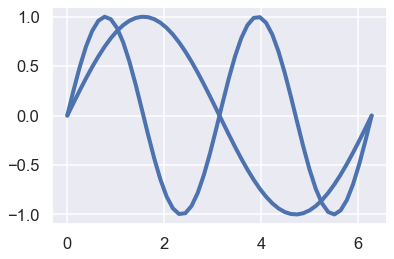

In [26]:
x = linspace(0, 2*pi)
y1 = sin(x)
y2 = sin(2*x)
lines = plt.plot(x, y1, x, y2)

# We will set the width and color of all lines in the figure at once:
plt.setp(lines, linewidth=4, color='b')

Finally, if you know what properties you want to set on a specific object, a
plain ``set`` call is typically the simplest form:

[None, None, None]

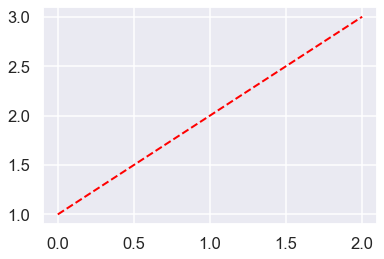

In [27]:
line, = plt.plot([1,2,3])
line.set(lw=2, c='red', ls='--')

## Understanding what matplotlib returns: lines, axes and figures


### Lines


In a simple plot:

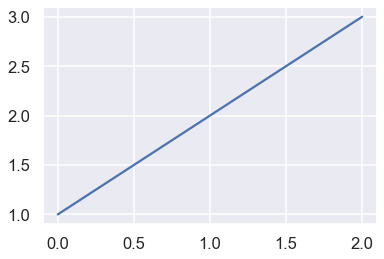

In [28]:
plt.plot([1,2,3])

The return value of the plot call is a list of lines, which can be manipulated
further.  If you capture the line object (in this case it's a single line so we
use a one-element tuple):

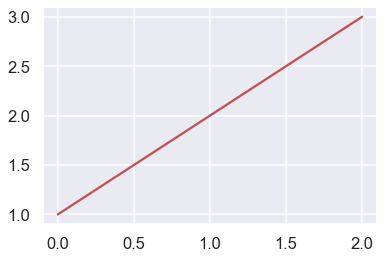

In [29]:
line, = plt.plot([1,2,3])
line.set_color('r')

One line property that is particularly useful to be aware of is ``set_data``:

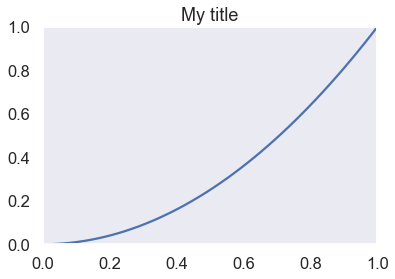

In [30]:
# Create a plot and hold the line object
line, = plt.plot([1,2,3], label='my data')
plt.grid()
plt.title('My title')

# ... later, we may want to modify the x/y data but keeping the rest of the
# figure intact, with our new data:
x = linspace(0, 1)
y = x**2

# This can be done by operating on the data object itself
line.set_data(x, y)

# Now we must set the axis limits manually. Note that we can also use xlim
# and ylim to set the x/y limits separately.
plt.axis([0,1,0,1])

# Note, alternatively this can be done with:
ax = plt.gca()  # get currently active axis object
ax.relim()
ax.autoscale_view()

### The next important component, axes

   
The ``axis`` call above was used to set the x/y limits of the axis.  And in
previous examples we called ``.plot`` directly on axis objects.  Axes are the
main object that contains a lot of the user-facing functionality of matplotlib:

    In [16]: fig, ax = plt.subplots()

    In [17]: ax.
    Display all 299 possibilities? (y or n)
    ax.acorr                                 ax.hitlist
    ax.add_artist                            ax.hlines
    ax.add_callback                          ax.hold
    ax.add_collection                        ax.ignore_existing_data_limits
    ax.add_line                              ax.images
    ax.add_patch                             ax.imshow
    
    ... etc.

Many of the commands in ``plt.<command>`` are nothing but wrappers around axis
calls, with machinery to automatically create a figure and add an axis to it if
there wasn't one to begin with.  The output of most axis actions that draw
something is a collection of lines (or other more complex geometric objects).

### Enclosing it all, the figure


The enclosing object is the ``figure``, that holds all axes:

    In [12]: fig, ax = plt.subplots(2, 1)

    In [13]: ax.shape
    Out[13]: (2,)

    In [14]: fig.axes
    Out[14]: 
    [<matplotlib.axes._subplots.AxesSubplot at 0x117c2c048>,
     <matplotlib.axes._subplots.AxesSubplot at 0x115739f98>]


**The basic view of matplotlib is: a figure contains one or more axes, axes draw
and return collections of one or more geometric objects (lines, patches, etc).**

For all the gory details on this topic, see the matplotlib [artist tutorial](http://matplotlib.sourceforge.net/users/artists.html), or the [chapter about matplotlib](http://aosabook.org/en/matplotlib.html) by its original author, John Hunter and core dev Michael Droetboom, in "The Architecture of Open Source Applications", which contains these useful diagrams:

In [40]:
%%html
<img src="http://www.aosabook.org/images/matplotlib/artists_figure.png", width="500px">
<img src="http://www.aosabook.org/images/matplotlib/artists_tree.png", width="500px">

## Aribitrary text and LaTeX support

In matplotlib, text can be added either relative to an individual axis object
or to the whole figure.

These commands add text to the Axes:

- title() - add a title
- xlabel() - add an axis label to the x-axis
- ylabel() - add an axis label to the y-axis
- text() - add text at an arbitrary location
- annotate() - add an annotation, with optional arrow

And these act on the whole figure:

- figtext() - add text at an arbitrary location
- suptitle() - add a title

And any text field can contain LaTeX expressions for mathematics, as long as
they are enclosed in ``$`` signs.

This example illustrates all of them:

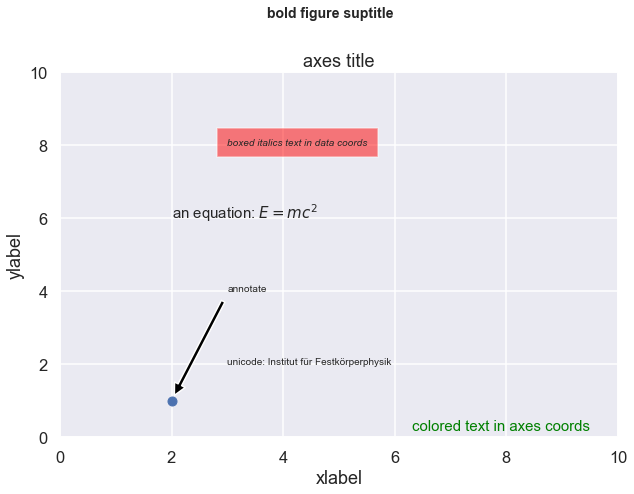

In [42]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('bold figure suptitle', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('axes title')

ax.set_xlabel('xlabel')
ax.set_ylabel('ylabel')

ax.text(3, 8, 'boxed italics text in data coords', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

ax.text(2, 6, 'an equation: $E=mc^2$', fontsize=15)

ax.text(3, 2, 'unicode: Institut für Festkörperphysik')

ax.text(0.95, 0.01, 'colored text in axes coords',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='green', fontsize=15)


ax.plot([2], [1], 'o')
ax.annotate('annotate', xy=(2, 1), xytext=(3, 4),
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.axis([0, 10, 0, 10]);

## Case Study

A real life example from Sam's research! This is the level of detail that needs to go into a publication-ready figure.

In [44]:
sam = pd.read_csv('sam_research.csv')
sam

,index,PID,condition,code,value
0,61,26330,control,Neuro,1.0
1,62,28234,control,Neuro,1.0
2,63,18700,control,Neuro,1.0
...,...,...,...,...,...
213,130,22381,treatment,Guessed,1.0
214,131,28567,treatment,Guessed,1.0
215,132,14173,treatment,Guessed,1.0


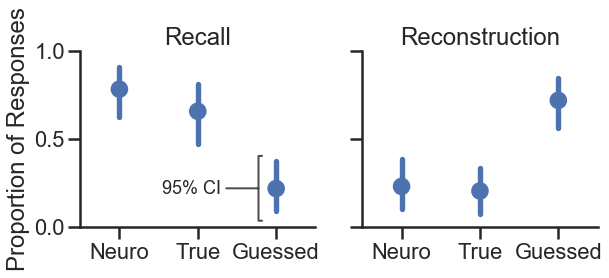

In [47]:
sns.set(style="ticks")
sns.set_context('poster')

# Set up figure
plt.figure(figsize=(9, 4))

# Make left chart
ax1 = plt.subplot(121)
sns.pointplot(x='code', y='value',
              data=sam.query('condition == "control"'),
              join=False, ax=ax1)
plt.ylabel('Proportion of Responses')
plt.title('Recall')

# Make right chart
ax2 = plt.subplot(122)
sns.pointplot(x='code', y='value',
              data=sam.query('condition == "treatment"'),
              join=False, ax=ax2)
ax2.set_ylabel('')
ax2.set_yticklabels([])
plt.title('Reconstruction')

# Adjust axis labels for both charts
ax = [ax1, ax2]
plt.setp(
    ax,
    xlabel='',
    yticks=(0, 0.5, 1),
    ylim=(0, 1),
)

# Add annotations
ax1.annotate('95% CI', xy=(1.8, 0.22), xytext=(1.3, 0.22),
             size=18, ha='right', va='center',
             arrowprops=dict(arrowstyle='-[,widthB=1.8', ec=(0.3, 0.3, 0.3)))

# Fine-tuning
sns.despine()
plt.tight_layout()
plt.subplots_adjust(wspace=.2)